# RQ4 validation plots

Carga el parquet final y genera dos gráficas:
1) `validation_present` vs `author_type`
2) `validation_type` vs `author_type`


In [10]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from scipy.stats import chi2_contingency
except ImportError:  # pragma: no cover - runtime warning if scipy missing
    chi2_contingency = None
    print("scipy is required for the chi-square test. Install it with `pip install scipy`.")

PARQUET_PATH = Path('./final_data/rq4_validation_evidence_final.parquet')

palette_pastel = ['#A3C4F3', '#C1E1C1', '#E2C2FF', '#B5E2FA']
sns.set_theme(style='whitegrid', palette=palette_pastel)
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.title_fontsize': 11,
    'legend.fontsize': 10,
})


final_df = pd.read_parquet(PARQUET_PATH)
print(f"Row: {len(final_df):,}")
print(f"Column: {list(final_df.columns)}")

final_df['author_type'] = final_df['author_type'].astype(str).str.strip().str.lower()
final_df['validation_type'] = final_df['validation_type'].astype(str).str.strip().str.lower()
final_df['validation_present'] = final_df['validation_present'].astype(bool)


Row: 407
Column: ['pr_id', 'author_type', 'repo', 'pr_number', 'pr_title', 'pipeline_names', 'validation_present', 'evidence_sources', 'validation_type', 'validation_description', 'pipeline_signal', 'description_signal', 'comment_signal']


In [11]:
# Statistical significance tests for validation signals across author types
contingency_table = (
    final_df
    .pivot_table(index='author_type', columns='validation_present', aggfunc='size', fill_value=0)
    .sort_index()
)

print('Validation_present counts by author type:')
print(contingency_table)

if chi2_contingency is None:
    print('Install scipy to compute the chi-square statistical significance test for validation presence.')
else:
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    total = contingency_table.values.sum()
    min_dim = min(contingency_table.shape)
    cramers_v = ((chi2_stat / (total * (min_dim - 1))) ** 0.5) if min_dim > 1 else float('nan')

    print()
    print('Validation_present chi-square test:')
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Cramer's V effect size: {cramers_v:.4f}")
    if p_value < 0.05:
        print('  Result: Significant difference detected (reject null hypothesis).')
    else:
        print('  Result: No significant difference detected at the 0.05 level.')

valtype_filtered = final_df[final_df['validation_type'].notna() & (final_df['validation_type'] != 'none')]

if valtype_filtered.empty:
    print('\nValidation_type counts by author type: no non-"none" validation types available for statistical testing.')
else:
    valtype_table = (
        valtype_filtered
        .pivot_table(index='author_type', columns='validation_type', aggfunc='size', fill_value=0)
        .sort_index()
    )
    print('\nValidation_type counts by author type (excluding "none"):')
    print(valtype_table)

    if chi2_contingency is None:
        print('Install scipy to compute the chi-square statistical significance test for validation types.')
    else:
        chi2_stat, p_value, dof, expected = chi2_contingency(valtype_table)
        total = valtype_table.values.sum()
        min_dim = min(valtype_table.shape)
        cramers_v = ((chi2_stat / (total * (min_dim - 1))) ** 0.5) if min_dim > 1 else float('nan')

        print()
        print('Validation_type chi-square test:')
        print(f"  Chi-square statistic: {chi2_stat:.4f}")
        print(f"  Degrees of freedom: {dof}")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Cramer's V effect size: {cramers_v:.4f}")
        if p_value < 0.05:
            print('  Result: Significant difference detected (reject null hypothesis).')
        else:
            print('  Result: No significant difference detected at the 0.05 level.')



Validation_present counts by author type:
validation_present  False  True 
author_type                     
ai_agent              190    134
human                  34     49

Validation_present chi-square test:
  Chi-square statistic: 7.6452
  Degrees of freedom: 1
  p-value: 0.005692
  Cramer's V effect size: 0.1371
  Result: Significant difference detected (reject null hypothesis).

Validation_type counts by author type (excluding "none"):
validation_type  anecdotal  benchmark  profiling  static-analysis
author_type                                                      
ai_agent                 4         37          6               87
human                    3         24          0               22

Validation_type chi-square test:
  Chi-square statistic: 10.4480
  Degrees of freedom: 3
  p-value: 0.015118
  Cramer's V effect size: 0.2389
  Result: Significant difference detected (reject null hypothesis).


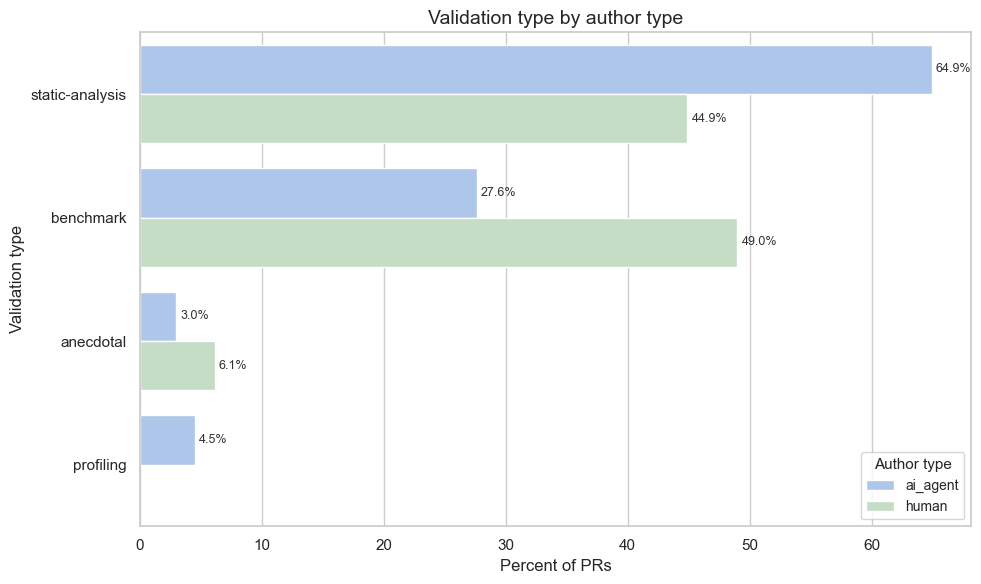

In [12]:
valtype_counts = (
    final_df[final_df['validation_type'] != 'none']
    .groupby(['validation_type', 'author_type'])
    .size()
    .reset_index(name='count')
)

author_totals = valtype_counts.groupby('author_type')['count'].sum()
valtype_counts['percent'] = valtype_counts.apply(
    lambda row: (row['count'] / author_totals[row['author_type']]) * 100,
    axis=1,
)

valtype_order = (
    valtype_counts.groupby('validation_type')['percent']
    .sum()
    .sort_values(ascending=False)
    .index
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=valtype_counts,
    y='validation_type',
    x='percent',
    hue='author_type',
    order=valtype_order,
    ax=ax,
)
ax.set_title('Validation type by author type')
ax.set_xlabel('Percent of PRs')
ax.set_ylabel('Validation type')
ax.legend(title='Author type', loc='lower right', frameon=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f"{width:.1f}%", (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=9, color='#333', xytext=(3, 0), textcoords='offset points')

plt.tight_layout()
plt.show()
